In [11]:
from dse.cluster import Cluster, GraphExecutionProfile, EXEC_PROFILE_GRAPH_DEFAULT
from dse.graph import GraphOptions, GraphProtocol
from dse_graph import DseGraph

from gremlin_python.process.graph_traversal import __
from gremlin_python.process.traversal import P
from gremlin_python.process.traversal import Scope, Column, Order, Direction

from math import radians, cos, sin, asin, sqrt

In [80]:
graph_name = "identity"
ep = GraphExecutionProfile(graph_options=GraphOptions(graph_name=graph_name,
                                                      graph_protocol=GraphProtocol.GRAPHSON_3_0))
cluster = Cluster(execution_profiles={EXEC_PROFILE_GRAPH_DEFAULT: ep})
session = cluster.connect()
g = DseGraph.traversal_source(session=session)

#### The results for one user: 947

In [24]:
timestamps = g.V().has("email_address", "email", "947"). \
               bothE(). \
               order(). \
                 by("datetime").valueMap(). \
               toList()
midpoint = int(len(timestamps)/2)
datetime = timestamps[midpoint]["datetime"]

In [46]:
candidates = g.V().has("email_address", "email", "947"). \
               bothE().has("datetime", P.lt(datetime)).otherV().dedup(). \
               bothE().has("datetime", P.gt(datetime)).otherV(). \
               groupCount(). \
                 by("email"). \
               order(Scope.local). \
                 by(Column.values, Order.desc). \
               unfold(). \
               limit(5). \
               toList()

In [47]:
candidates

[{'947': 3316}, {'418': 419}, {'782': 412}, {'435': 386}, {'40': 356}]

#### The results for all users

In [36]:
vertex_ids = g.V().hasLabel("email_address").values("email").toList()

In [40]:
time_splits = {} # a data structure to track the 1/2 way point for each vertex
for vertex in vertex_ids:
    times = g.V().has("email_address", "email", vertex). \
            bothE().order(). \
            by("datetime").valueMap(). \
            toList()
    midpoint = int(len(times)/2)
    if midpoint > 0:
        time_splits[vertex] = times[midpoint].get("datetime")

In [48]:
results = {}
for vertex, datetime in time_splits.items():
    answer = g.V().has("email_address", "email", vertex). \
                   bothE().has("datetime", P.lt(datetime)).otherV().dedup(). \
                   bothE().has("datetime", P.gt(datetime)).otherV(). \
                   groupCount(). \
                     by("email"). \
                   order(Scope.local). \
                     by(Column.values, Order.desc). \
                   unfold(). \
                   limit(1). \
                   toList()
    results[vertex] = answer

#### Analyze the results: total correct answers

In [76]:
results

{'631': [{'629': 3476}],
 '403': [{'514': 20}],
 '492': [{'891': 75}],
 '517': [{'168': 2627}],
 '789': [{'987': 5002}],
 '947': [{'947': 2561}],
 '255': [{'147': 201}],
 '326': [{'746': 824}],
 '374': [{'418': 384}],
 '151': [{'288': 671}],
 '837': [{'774': 2911}],
 '840': [{'987': 1739}],
 '925': [{'987': 1494}],
 '554': [{'923': 50}],
 '6': [{'178': 1412}],
 '880': [{'288': 733}],
 '828': [{'506': 1482}],
 '483': [{'718': 810}],
 '191': [{'746': 1725}],
 '411': [{'996': 393}],
 '682': [{'738': 938}],
 '697': [{'987': 722}],
 '794': [{'915': 225}],
 '752': [{'912': 1406}],
 '909': [{'178': 669}],
 '630': [{'629': 2905}],
 '787': [{'790': 305}],
 '493': [{'629': 3329}],
 '90': [{'168': 3889}],
 '957': [{'978': 780}],
 '163': [{'62': 163}],
 '200': [{'316': 2684}],
 '532': [{'506': 1377}],
 '223': [{'935': 1142}],
 '613': [{'178': 733}],
 '616': [{'418': 432}],
 '294': [{'912': 2538}],
 '528': [{'923': 675}],
 '886': [{'886': 78}],
 '458': [{'684': 531}],
 '850': [{'506': 1136}],
 '792

In [78]:
total_correct = 0
for vertex, answer in results.items():
    if vertex == list(answer[0].keys())[0]:
        total_correct += 1
    else:
        print(vertex, answer)
percent_correct = 100*(total_correct/len(results))
print(percent_correct)

631 [{'629': 3476}]
403 [{'514': 20}]
492 [{'891': 75}]
517 [{'168': 2627}]
789 [{'987': 5002}]
255 [{'147': 201}]
326 [{'746': 824}]
374 [{'418': 384}]
151 [{'288': 671}]
837 [{'774': 2911}]
840 [{'987': 1739}]
925 [{'987': 1494}]
554 [{'923': 50}]
6 [{'178': 1412}]
880 [{'288': 733}]
828 [{'506': 1482}]
483 [{'718': 810}]
191 [{'746': 1725}]
411 [{'996': 393}]
682 [{'738': 938}]
697 [{'987': 722}]
794 [{'915': 225}]
752 [{'912': 1406}]
909 [{'178': 669}]
630 [{'629': 2905}]
787 [{'790': 305}]
493 [{'629': 3329}]
90 [{'168': 3889}]
957 [{'978': 780}]
163 [{'62': 163}]
200 [{'316': 2684}]
532 [{'506': 1377}]
223 [{'935': 1142}]
613 [{'178': 733}]
616 [{'418': 432}]
294 [{'912': 2538}]
528 [{'923': 675}]
458 [{'684': 531}]
850 [{'506': 1136}]
792 [{'15': 62}]
221 [{'935': 1081}]
308 [{'996': 1928}]
546 [{'168': 1756}]
144 [{'849': 257}]
46 [{'343': 173}]
115 [{'407': 71}]
55 [{'178': 107}]
712 [{'774': 3974}]
225 [{'423': 175}]
1002 [{'923': 80}]
257 [{'401': 1016}]
883 [{'718': 1345}]


#### Analyze the results: total correct answers according to number of unique contacts

In [ ]:
num_friends = g.V().hasLabel("email_address"). \
                project(values("email"))

In [83]:
results_no_dedup = {}
for vertex, datetime in time_splits.items():
    try:
        answer = g.V().has("email_address", "email", vertex). \
                       bothE().has("datetime", P.lt(datetime)).otherV(). \
                       bothE().has("datetime", P.gt(datetime)).otherV(). \
                       groupCount(). \
                         by("email"). \
                       order(Scope.local). \
                         by(Column.values, Order.desc). \
                       unfold(). \
                       limit(1). \
                       toList()
        results_no_dedup[vertex] = answer
    except Exception as e:
        print("took to long for: ", vertex)
        pass
total_correct = 0
for vertex, answer in results_no_dedup.items():
    if vertex == list(answer[0].keys())[0]:
        total_correct += 1
    else:
        print(vertex, answer)
percent_correct = 100*(total_correct/len(results))
print(percent_correct)

took to long for:  947
took to long for:  630
took to long for:  200
took to long for:  356
took to long for:  429
took to long for:  416
took to long for:  159
took to long for:  949
took to long for:  586
took to long for:  996
took to long for:  790
took to long for:  231
took to long for:  592
took to long for:  472
took to long for:  214
took to long for:  280
took to long for:  540
took to long for:  765
took to long for:  746
took to long for:  987


KeyboardInterrupt: 

In [84]:
results_no_dedup

{'631': [{'288': 135673}],
 '403': [{'514': 20}],
 '492': [{'891': 75}],
 '517': [{'586': 39692}],
 '789': [{'178': 87128}],
 '255': [{'147': 605}],
 '326': [{'772': 3186}],
 '374': [{'418': 28800}],
 '151': [{'151': 5452}],
 '837': [{'738': 7845}],
 '840': [{'987': 52471}],
 '925': [{'540': 34755}],
 '554': [{'833': 136}],
 '6': [{'605': 61573}],
 '880': [{'98': 14199}],
 '828': [{'506': 6364}],
 '483': [{'696': 4556}],
 '191': [{'401': 35742}],
 '411': [{'996': 1872}],
 '682': [{'738': 18160}],
 '697': [{'697': 62434}],
 '794': [{'586': 888}],
 '752': [{'772': 7126}],
 '909': [{'178': 15059}],
 '787': [{'214': 4420}],
 '493': [{'288': 205949}],
 '90': [{'168': 45821}],
 '957': [{'851': 18681}],
 '163': [{'518': 1005}],
 '532': [{'532': 28451}],
 '223': [{'663': 14275}],
 '613': [{'731': 1543}],
 '616': [{'418': 864}],
 '294': [{'782': 112230}],
 '528': [{'362': 4967}],
 '886': [{'886': 6240}],
 '458': [{'458': 18425}],
 '850': [{'418': 24630}],
 '792': [{'15': 62}],
 '221': [{'935': 

In [86]:
total_correct = 0
for vertex, answer in results_no_dedup.items():
    if vertex == list(answer[0].keys())[0]:
        total_correct += 1
percent_correct = 100*(total_correct/len(results))
print(percent_correct)

3.8461538461538463


#### Results w/ uniqueness

In [133]:
results = {}
counter = 0
graph = {}
for vertex, datetime in time_splits.items():
    if counter % 100 == 0:
        print(counter, "out of", len(time_splits))
    try:
        friends = g.V().has("email_address", "email", vertex).\
                       bothE().has("datetime", P.lt(datetime)).otherV().\
                       dedup().values("email").toList()
        candidates = {}
        for friend in friends:
            candidate_list = g.V().has("email_address", "email", friend).\
                               bothE().has("datetime", P.gt(datetime)).otherV(). \
                               dedup().\
                               values("email").toList()
            for candidate in candidate_list:
                if candidates.get(candidate):
                    candidates[candidate] += 1
                else:
                    candidates[candidate] = 1
        rankings = [(k, candidates[k]) for k in sorted(candidates, key=candidates.get, reverse=True)]
        graph[vertex] = [friends, candidates, rankings, rankings[0][0]]
        results[vertex] = rankings[0][0]
    except Exception as e:
        print(str(e.message))
        print("failed for: ", vertex)
        pass
    finally:
        counter += 1

0 out of 936
100 out of 936
200 out of 936
300 out of 936
400 out of 936
500 out of 936
600 out of 936
700 out of 936
800 out of 936
900 out of 936


##### results by size of neighborhood

In [ ]:
degree = {}
for vertex, datetime in time_splits.items():
    friends = g.V().has("email_address", "email", vertex).\
                       bothE().has("datetime", P.lt(datetime)).otherV().\
                       dedup().count().next()
    degree[vertex] = friends

In [143]:
sorted_degrees = []
for key, val in degree.items():
    sorted_degrees.append(val)
sorted_degrees = list(set(sorted_degrees))
print(sorted_degrees)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 98, 101, 102, 103, 105, 106, 107, 113, 115, 119, 122, 124, 129, 130, 140, 142, 149, 159, 183, 187, 273]


In [149]:
results["103"]

'832'

In [155]:
results_distribution = {}
for neighborhood_thres in sorted_degrees:
    total_correct = 0.0
    total_candidates = 0.0
    for vertex, answer in results.items():
        if degree.get(vertex) >= neighborhood_thres:
            total_candidates += 1
            if vertex == answer:
                total_correct += 1
    percent_correct = 100*(total_correct/total_candidates)
    results_distribution[neighborhood_thres] = [percent_correct,total_correct,total_candidates]   
print(results_distribution)   

{1: [25.213675213675213, 236.0, 936.0], 2: [27.27272727272727, 231.0, 847.0], 3: [28.71536523929471, 228.0, 794.0], 4: [29.78723404255319, 224.0, 752.0], 5: [30.651872399445214, 221.0, 721.0], 6: [31.054131054131055, 218.0, 702.0], 7: [31.851851851851855, 215.0, 675.0], 8: [32.25308641975309, 209.0, 648.0], 9: [32.278481012658226, 204.0, 632.0], 10: [33.27841845140033, 202.0, 607.0], 11: [34.07534246575342, 199.0, 584.0], 12: [34.63587921847247, 195.0, 563.0], 13: [34.50184501845018, 187.0, 542.0], 14: [34.8747591522158, 181.0, 519.0], 15: [35.45816733067729, 178.0, 502.0], 16: [36.477987421383645, 174.0, 477.0], 17: [36.933045356371494, 171.0, 463.0], 18: [36.93693693693694, 164.0, 444.0], 19: [37.5886524822695, 159.0, 423.0], 20: [37.0, 148.0, 400.0], 21: [38.1201044386423, 146.0, 383.0], 22: [38.44086021505376, 143.0, 372.0], 23: [39.49579831932773, 141.0, 357.0], 24: [40.35608308605341, 136.0, 337.0], 25: [42.45283018867924, 135.0, 318.0], 26: [42.295081967213115, 129.0, 305.0], 27

In [152]:
import sys
!{sys.executable} -m pip install matplotlib

     |████████████████████████████████| 14.4MB 7.7MB/s eta 0:00:01
     |████████████████████████████████| 122kB 14.2MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


<IPython.core.display.Javascript object>


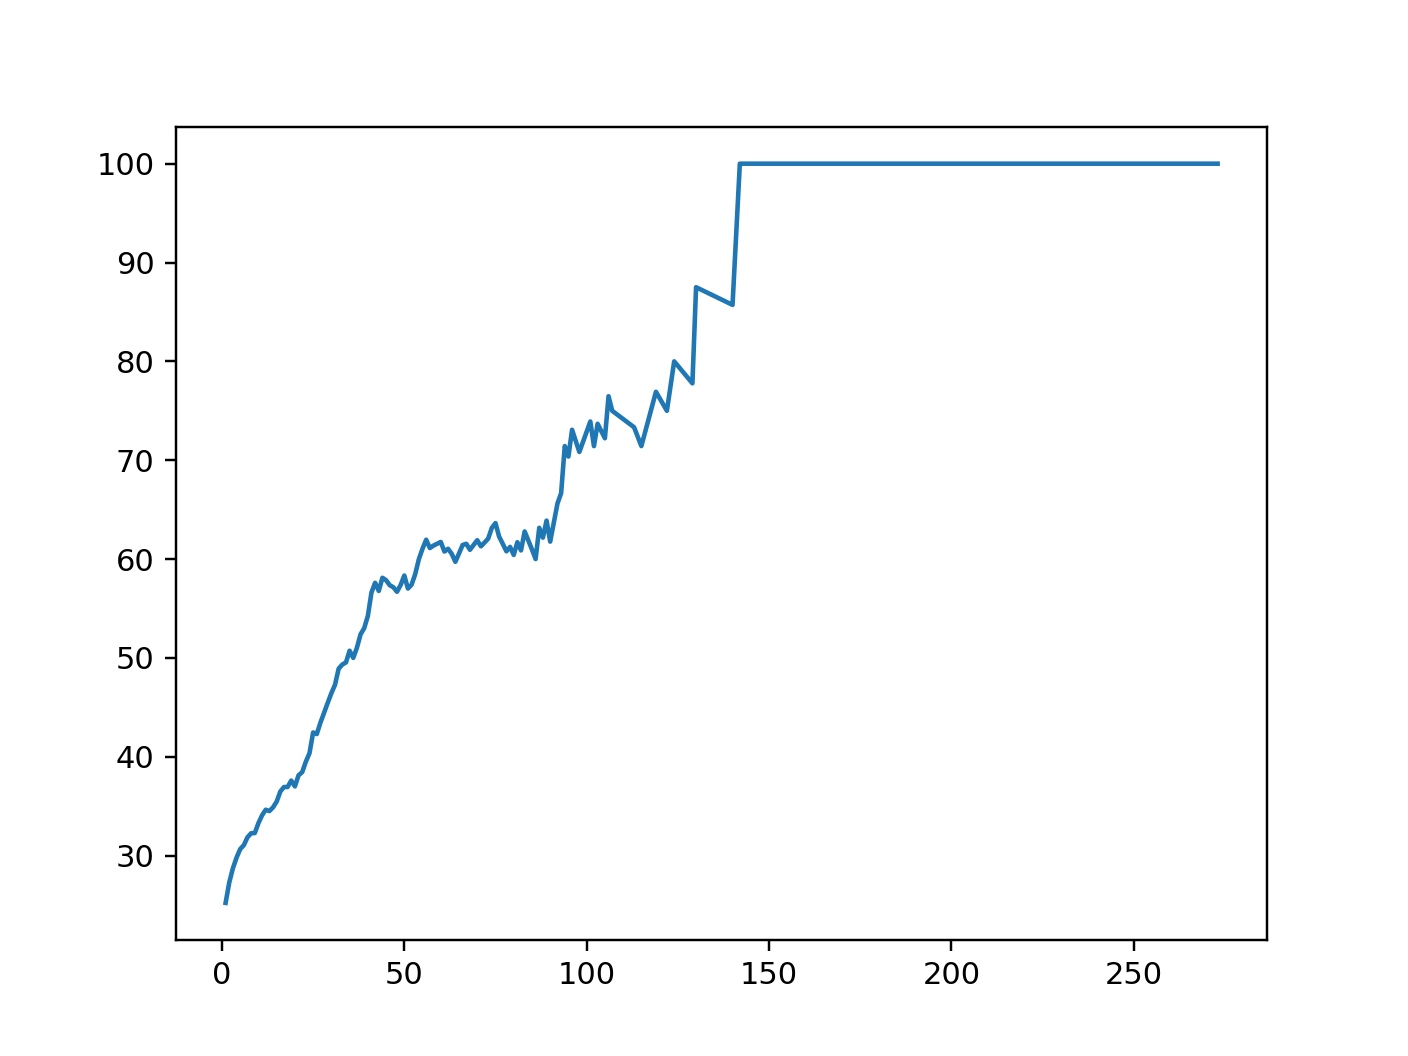

In [154]:
import matplotlib.pylab as plt
%matplotlib notebook
lists = sorted(results_distribution.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

In [131]:
degree = {}
for vertex, datetime in time_splits.items():
    friends = g.V().has("email_address", "email", vertex).\
                       bothE().has("datetime", P.lt(datetime)).otherV().\
                       dedup().count().next()
    degree[vertex] = friends

In [132]:
degree

{'631': 20,
 '403': 5,
 '492': 1,
 '517': 81,
 '789': 48,
 '947': 28,
 '255': 6,
 '326': 18,
 '374': 12,
 '151': 17,
 '837': 26,
 '840': 25,
 '925': 13,
 '554': 2,
 '6': 29,
 '880': 26,
 '828': 40,
 '483': 29,
 '191': 35,
 '411': 2,
 '682': 19,
 '697': 17,
 '794': 10,
 '752': 64,
 '909': 17,
 '630': 58,
 '787': 4,
 '493': 28,
 '90': 273,
 '957': 19,
 '163': 12,
 '200': 40,
 '532': 73,
 '223': 30,
 '613': 15,
 '616': 1,
 '294': 39,
 '528': 86,
 '886': 2,
 '458': 25,
 '850': 70,
 '792': 2,
 '221': 1,
 '308': 7,
 '546': 98,
 '144': 6,
 '46': 18,
 '115': 2,
 '55': 10,
 '712': 35,
 '225': 13,
 '180': 7,
 '1002': 5,
 '257': 23,
 '883': 48,
 '963': 26,
 '251': 23,
 '393': 14,
 '81': 1,
 '265': 3,
 '353': 10,
 '737': 12,
 '312': 1,
 '288': 13,
 '285': 12,
 '149': 32,
 '16': 44,
 '888': 10,
 '893': 8,
 '855': 19,
 '176': 21,
 '923': 113,
 '981': 2,
 '158': 10,
 '806': 25,
 '324': 41,
 '229': 42,
 '847': 20,
 '408': 9,
 '283': 6,
 '902': 5,
 '975': 5,
 '453': 1,
 '939': 32,
 '474': 8,
 '262': 2,

In [102]:
results

{'631': '280',
 '403': '403',
 '492': '506',
 '517': '517',
 '789': '789',
 '947': '586',
 '255': '147',
 '326': '61',
 '374': '863',
 '151': '120',
 '837': '719',
 '840': '840',
 '925': '789',
 '554': '720',
 '6': '189',
 '880': '120',
 '828': '644',
 '483': '334',
 '191': '120',
 '411': '977',
 '682': '506',
 '697': '697',
 '794': '120',
 '752': '120',
 '909': '909',
 '630': '630',
 '787': '306',
 '493': '280',
 '90': '90',
 '957': '957',
 '163': '518',
 '200': '915',
 '532': '506',
 '223': '534',
 '613': '120',
 '616': '418',
 '294': '416',
 '528': '120',
 '886': '749',
 '458': '458',
 '850': '850',
 '792': '229',
 '221': '413',
 '308': '308',
 '546': '214',
 '144': '890',
 '46': '46',
 '115': '687',
 '55': '506',
 '712': '40',
 '225': '184',
 '180': '180',
 '1002': '736',
 '257': '772',
 '883': '718',
 '963': '692',
 '251': '789',
 '393': '393',
 '81': '848',
 '265': '293',
 '353': '280',
 '737': '737',
 '312': '0',
 '288': '288',
 '285': '933',
 '149': '716',
 '16': '718',
 '888':

In [103]:
total_correct = 0
for vertex, answer in results.items():
    if vertex == answer:
        total_correct += 1
percent_correct = 100*(total_correct/len(results))
print(percent_correct)    

25.427350427350426


In [100]:
if 100 % 10 == 0:
    print("yes")

yes


In [99]:
rankings = [(k, candidates[k]) for k in sorted(candidates, key=candidates.get, reverse=True)]
winner = rankings[0][0]
"90" == winner

True

In [95]:
rankings = [(k, candidates[k]) for k in sorted(candidates, key=candidates.get, reverse=True)]

In [98]:
s[0][0]

'90'

#### Uniquness + close friends only

In [117]:
results = g.V().has("email_address", "email", "90").\
                       bothE().has("datetime", P.lt(datetime)).otherV().\
                       groupCount(). \
                         by("email"). \
                       order(Scope.local). \
                         by(Column.values, Order.desc). \
                       unfold(). \
                       limit(20). \
                       toList()
friends = []
for item in results:
    for v,count in item.items():
        friends.append(v)

In [118]:
friends

['742',
 '927',
 '850',
 '416',
 '316',
 '178',
 '506',
 '356',
 '107',
 '220',
 '191',
 '248',
 '692',
 '915',
 '718',
 '997',
 '40',
 '135',
 '32',
 '236']

In [109]:
friends

['742']

In [121]:
results = {}
counter = 0
for vertex, datetime in time_splits.items():
    if counter % 100 == 0:
        print("Trying vertex: ", vertex)
        print(counter)
    try:
        counted_friends = g.V().has("email_address", "email", "90").\
                       bothE().has("datetime", P.lt(datetime)).otherV().\
                       groupCount(). \
                         by("email"). \
                       order(Scope.local). \
                         by(Column.values, Order.desc). \
                       unfold(). \
                       limit(20). \
                       toList()
        friends = []
        for item in counted_friends:
            for v,count in item.items():
                friends.append(v)
        candidates = {}
        for friend in friends:
            candidate_list = g.V().has("email_address", "email", friend).\
                               bothE().has("datetime", P.gt(datetime)).otherV(). \
                               dedup().\
                               values("email").toList()
            for candidate in candidate_list:
                if candidates.get(candidate):
                    candidates[candidate] += 1
                else:
                    candidates[candidate] = 1
        rankings = [(k, candidates[k]) for k in sorted(candidates, key=candidates.get, reverse=True)]
        results[vertex] = rankings[0][0]
    except Exception as e:
        print(str(e))
        print("failed for: ", vertex)
        pass
    finally:
        counter += 1

Trying vertex:  631
0
Trying vertex:  739
100
Trying vertex:  478
200
Trying vertex:  513
300
Trying vertex:  53
400
Trying vertex:  821
500
Trying vertex:  961
600
Trying vertex:  31
700
Trying vertex:  960
800
Trying vertex:  530
900


In [ ]:
total_correct = 0
for vertex, answer in results.items():
    if vertex == answer:
        total_correct += 1
percent_correct = 100*(total_correct/len(results))
print(percent_correct)   

#### Results by neighborhood size

In [ ]:
neighborhood = 0
for vertex, datetime in time_splits.items():
    counted_friends = g.V().has("email_address", "email", "90").\
                       bothE().has("datetime", P.lt(datetime)).otherV()